Python environment

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
sc.settings.n_jobs = 8

In [ ]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

## Mapping Ruiz2021 dataset

### Load query datasset

In [ ]:
adata = sc.read('data/core_GBmap.h5ad')
adata

AnnData object with n_obs × n_vars = 431535 × 36498
    obs: 'author', 'patient', 'celltype_malignant', 'celltype_major', 'celltype_minor', 'gender', 'location', 'EGFR', 'platform', 'method', 'age', 'MET', 'p53', 'TERT', 'ATRX', 'PTEN', 'MGMT', 'sample', 'celltype_original', 'KI_67', 'region', 'Tissue', 'chr1p19q', 'stage', 'Verhaak_classification', 'PDGFR', 'gs_prediction', 'gs_prediction_main', 'gs_prediction_detailed', 'cnv_full_geneset', 'cnv_filtered_geneset', 'celltype_assigned'
    var: 'gene_ids', 'feature_types', 'genome'

In [ ]:
adata.layers["counts"] = adata.X.copy()

In [ ]:
target_adata = adata[adata.obs['author'].isin(['Ruiz2021'])].copy()

### Perform surgery on reference model and train on query dataset without cell type labels

In [ ]:
ref_path = 'scarches_models/ref_model_scanvi/'
model = sca.models.SCANVI.load_query_data(
    target_adata,
    ref_path,
    freeze_dropout = True,
)

INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 39355 cells, 5000 vars, 18        
         batches, 14 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  


In [ ]:
model._unlabeled_indices = np.arange(target_adata.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))

Labelled Indices:  0
Unlabelled Indices:  39355


In [ ]:
condition_key = 'author'
cell_type_key = 'celltype_assigned'

vae_epochs = 500
scanvi_epochs = 200
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_scanvi = {
    "early_stopping_metric": "accuracy",
    "save_best_state_metric": "accuracy",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_surgery = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

In [ ]:
model.train(
    n_epochs_semisupervised=surgery_epochs,
    train_base_model=False,
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["accuracy", "elbo"],
                                       weight_decay=0,
                                       early_stopping_kwargs=early_stopping_kwargs_surgery
                                      ),
    frequency=1
)

INFO     Training Unsupervised Trainer for 203 epochs.                                       
INFO     Training SemiSupervised Trainer for 500 epochs.                                     
INFO     KL warmup for 400 epochs                                                            
Training...: 100%|██████████| 500/500 [1:31:13<00:00, 10.95s/it]
INFO     Training time:  1803 s. / 500 epochs                                                


In [ ]:
query_latent = sc.AnnData(model.get_latent_representation())

In [ ]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)

... storing 'predictions' as categorical


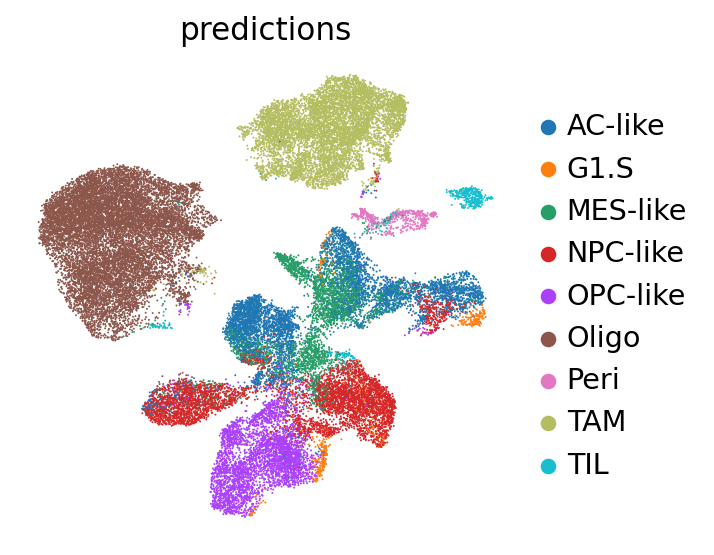

In [ ]:
query_latent.obs['predictions'] = model.predict()
sc.pl.umap(query_latent,
           color=['predictions'],
           frameon=False,
           wspace=0.6,
           )

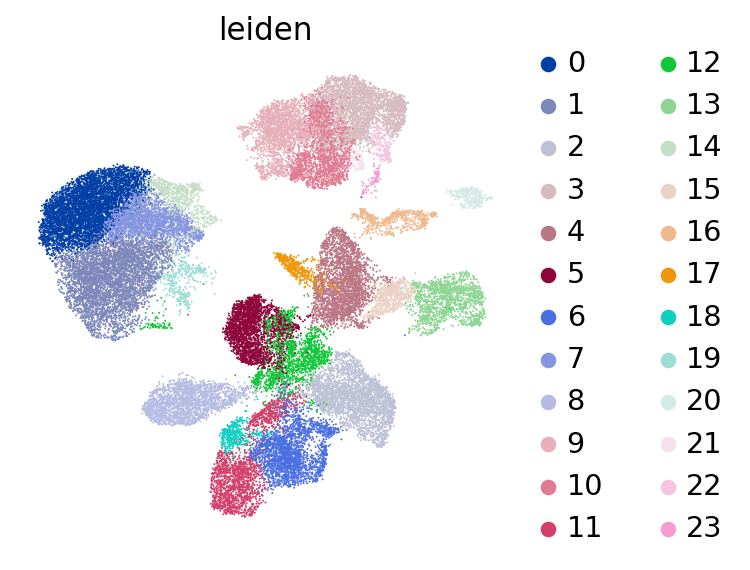

In [ ]:
sc.pl.umap(query_latent,
           color=['leiden'],
           frameon=False,
           wspace=0.6,
           )

In [ ]:
query_latent.write_h5ad('data/Ruiz2021_scacrhes_scanpy_clustering.h5ad')